In [2]:
import glob
import sys
import os
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import scipy as spy
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import ssl
import pickle, json
import src.main as lc
import old_lc.main as olc
from src.models.LeNet import LeNet
import src.compression.deltaCompress as lc_compress
from src.models.LeNet_LowRank import getBase, LeNet_LowRank, load_sd_decomp
from src.utils.utils import evaluate_accuracy, lazy_restore, evaluate_compression

In [3]:
HDFP = "./volumes/Ultra Touch" # Load HHD

def data_loader():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.1307, 0.3081)])

    trainset = datasets.MNIST(root='./data', train=True,
                                          download=True, transform=transform)
    # Reintroduce the 2000 datapoints model has not seen before.
    trainset.data = trainset.data.clone()[-2000:-1000]
    trainset.targets = trainset.targets.clone()[-2000:-1000]
    trainloader = torch.utils.data.DataLoader(trainset, batch_size = 32,
                                              shuffle=False, num_workers=2)

    testset = datasets.MNIST(root='./data', train=False,
                                         download=True, transform=transform)

    testset.data = trainset.data[-1000:]
    testset.targets = trainset.targets[-1000:]
    testloader = torch.utils.data.DataLoader(testset, batch_size = 32,
                                             shuffle=False, num_workers=2)
    
    testloader = torch.utils.data.DataLoader(testset, batch_size = 32,
                                             shuffle=False, num_workers=2)
    
    return trainloader, testloader

In [4]:
# Bypass using SSL unverified
ssl._create_default_https_context = ssl._create_unverified_context
# MNIST dataset 
train_loader, test_loader = data_loader()

In [5]:
SAVE_LOC = HDFP + "/lobranch-snapshot/diffbitwidth-adaptive-rank/lenet/lobranch"
if not os.path.exists(SAVE_LOC):
    os.makedirs(SAVE_LOC)

SAVE_LOC_OLC = HDFP + "/lobranch-snapshot/diffbitwidth-adaptive-rank/lenet/old-lc"
if not os.path.exists(SAVE_LOC_OLC):
    os.makedirs(SAVE_LOC_OLC)

In [6]:
DECOMPOSED_LAYERS = ['classifier.1.weight', 'classifier.3.weight']
RANK = -1
SCALING = -1
BRANCH_ACC = "0.775"

original = LeNet()
model_original = LeNet()

# Load from "branch point"
BRANCH_LOC = HDFP + "/lobranch-snapshot/branchpoints/lenet/branch_{}.pt".format(BRANCH_ACC)
original.load_state_dict(torch.load(BRANCH_LOC))
model_original.load_state_dict(torch.load(BRANCH_LOC))

w, b = getBase(model_original)
model = LeNet_LowRank(w, b, rank = RANK)
load_sd_decomp(torch.load(BRANCH_LOC), model, DECOMPOSED_LAYERS)
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
optimizer_full = torch.optim.SGD(model_original.parameters(), lr = learning_rate)

In [14]:
delta_normal_max = []
delta_normal_min = []
delta_decomposed_max = []
delta_decomposed_min = []
full_accuracy = []
decomposed_full_accuracy = []
restored_accuracy = []
lc_accuracy = []
current_iter = 0
current_set = 0

current_iter_old_lc = 0
current_set_old_lc = 0

acc = lambda x, y : (torch.max(x, 1)[1] == y).sum().item() / y.size(0)

for epch in range(20):
    for i, data in enumerate(train_loader, 0):
        print("Epoch: {}, Iteration: {}".format(epch, i))
        
        set_path = "/set_{}".format(current_set)
        if not os.path.exists(SAVE_LOC + set_path):
            os.makedirs(SAVE_LOC + set_path)

        if i == 0 and epch == 0: # first iteration, create baseline model
            base, base_decomp = lc.extract_weights(model, SAVE_LOC + 
                                                       "/set_{}".format(current_set), DECOMPOSED_LAYERS)
        else:
            if i % 10 == 0: 
                # full snapshot!
                new_model = lazy_restore(base, base_decomp, bias, LeNet(), 
                                          original.state_dict(), DECOMPOSED_LAYERS, rank = RANK, scaling = SCALING)
                original = new_model # Changing previous "original model" used to restore the loRA model.
                
                current_set += 1
                current_iter = 0

                set_path = "/set_{}".format(current_set)
                if not os.path.exists(SAVE_LOC + set_path):
                    os.makedirs(SAVE_LOC + set_path)
                
                # Rebuilding LoRA layers => reset model!
                w, b = getBase(original)
                model = LeNet_LowRank(w, b, rank = RANK)
                optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
                load_sd_decomp(original.state_dict(), model, DECOMPOSED_LAYERS)
                base, base_decomp = lc.extract_weights(model, SAVE_LOC + 
                                                       "/set_{}".format(current_set), DECOMPOSED_LAYERS)

            else:
                # Delta-compression
                delta, decomp_delta, bias = lc.generate_delta(base, 
                                                                base_decomp, model.state_dict(), DECOMPOSED_LAYERS)
                compressed_delta, full_delta, compressed_dcomp_delta, full_dcomp_delta  = lc.compress_delta(delta, 
                                                                                                            decomp_delta)
                
                # Saving checkpoint
                lc.save_checkpoint(compressed_delta, compressed_dcomp_delta, bias, current_iter, SAVE_LOC + 
                                "/set_{}".format(current_set))
    
                base = np.add(base, full_delta) # Replace base with latest for delta to accumulate.
                base_decomp = np.add(full_dcomp_delta, base_decomp)

                current_iter += 1
            
        # ==========================
        # Saving using LC-Checkpoint
        # ==========================
                
        if i == 0 and epch == 0:
            cstate = model_original.state_dict()
            set_path = "/set_{}".format(current_set_old_lc)
            if not os.path.exists(SAVE_LOC_OLC + set_path):
                os.makedirs(SAVE_LOC_OLC + set_path)
            torch.save(cstate, SAVE_LOC_OLC + set_path + "/initial_model.pt")
            prev_state = olc.extract_weights(model_original)
        else:
            if i % 10 == 0:
                cstate = model_original.state_dict()
                current_set_old_lc += 1
                current_iter_old_lc = 0
                set_path = "/set_{}".format(current_set_old_lc)
                if not os.path.exists(SAVE_LOC_OLC + set_path):
                    os.makedirs(SAVE_LOC_OLC + set_path)
                torch.save(cstate, SAVE_LOC_OLC + set_path + "/initial_model.pt")
                prev_state = olc.extract_weights(model_original)
            else:
                cstate = model_original.state_dict()
                old_lc_delta, old_lc_bias, _ = olc.generate_delta(prev_state, cstate)
                olc_compressed_delta, update_prev = olc.compress_data(old_lc_delta, num_bits = 3)
                olc.save_checkpoint(SAVE_LOC_OLC + "/set_{}".format(current_set_old_lc), olc_compressed_delta, 
                                    old_lc_bias, epch, current_iter_old_lc)
                prev_state = np.add(prev_state, update_prev)
                current_iter_old_lc += 1
        
        # ==========================
        # Training on Low-Rank Model
        # ==========================

        # Get the inputs and labels
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = torch.nn.functional.cross_entropy(outputs,labels)
        loss.backward()
        optimizer.step()
            
        # ======================
        # Training on Full Model
        # ======================

        # Zero the parameter gradients
        optimizer_full.zero_grad()

        # Forward + backward + optimize
        outputs_full = model_original(inputs)
        loss_full = torch.nn.functional.cross_entropy(outputs_full,labels)
        loss_full.backward()
        optimizer_full.step()

        if i % 20 == 0:
            print("Training Accuracy | Decomposed: {}, Full : {}".format(acc(outputs, labels), 
                                                                         acc(outputs_full, labels)))

        if i != 0  and i % 5 == 0: # Evaluation on testing set
            full_accuracy.append(evaluate_accuracy(model_original, test_loader))
            decomposed_full_accuracy.append(evaluate_accuracy(model, test_loader))
            restored_model = lazy_restore(base, base_decomp, bias, LeNet(), 
                                          original.state_dict(), DECOMPOSED_LAYERS, 
                                          rank = RANK, scaling = SCALING)
            restored_accuracy.append(evaluate_accuracy(restored_model, test_loader))
            restored_lc_model = LeNet()
            restored_lc_model.load_state_dict(olc.restore_state_dict(prev_state, old_lc_bias, 
                                                                  restored_model.state_dict()))
            lc_accuracy.append(evaluate_accuracy(restored_lc_model, test_loader))
            print("Full accuracy: {}, LC accuracy: {}, Decomposed-Full accuracy: {}, Decomposed-Restored accuracy: {}".format(
                full_accuracy[-1], lc_accuracy[-1], decomposed_full_accuracy[-1], restored_accuracy[-1]))

Epoch: 0, Iteration: 0
saving full base model @ /volumes/Ultra Touch/lobranch-snapshot/diffbitwidth-adaptive-rank/lenet/lobranch/set_0/base_model.pt
Training Accuracy | Decomposed: 0.78125, Full : 0.78125
Epoch: 0, Iteration: 1
Saving Checkpoint lc_checkpoint_0.pt @ /volumes/Ultra Touch/lobranch-snapshot/diffbitwidth-adaptive-rank/lenet/lobranch/set_0
Epoch: 0, Iteration: 2
Saving Checkpoint lc_checkpoint_1.pt @ /volumes/Ultra Touch/lobranch-snapshot/diffbitwidth-adaptive-rank/lenet/lobranch/set_0
Epoch: 0, Iteration: 3
Saving Checkpoint lc_checkpoint_2.pt @ /volumes/Ultra Touch/lobranch-snapshot/diffbitwidth-adaptive-rank/lenet/lobranch/set_0
Epoch: 0, Iteration: 4
Saving Checkpoint lc_checkpoint_3.pt @ /volumes/Ultra Touch/lobranch-snapshot/diffbitwidth-adaptive-rank/lenet/lobranch/set_0
Epoch: 0, Iteration: 5
Saving Checkpoint lc_checkpoint_4.pt @ /volumes/Ultra Touch/lobranch-snapshot/diffbitwidth-adaptive-rank/lenet/lobranch/set_0
model accuracy: 0.829
model accuracy: 0.829
model 

In [7]:
import json

with open(HDFP + "/lobranch-snapshot/diffbitwidth-adaptive-rank/lenet/data.json") as f:
    data = json.load(f)
full_accuracy = data['full_acc']
lc_accuracy = data["lc_restored_accuracy"]
restored_accuracy = data["decomposed_restored_accuracy"]
decomposed_full_accuracy = data["decomposed_full_accuracy"]


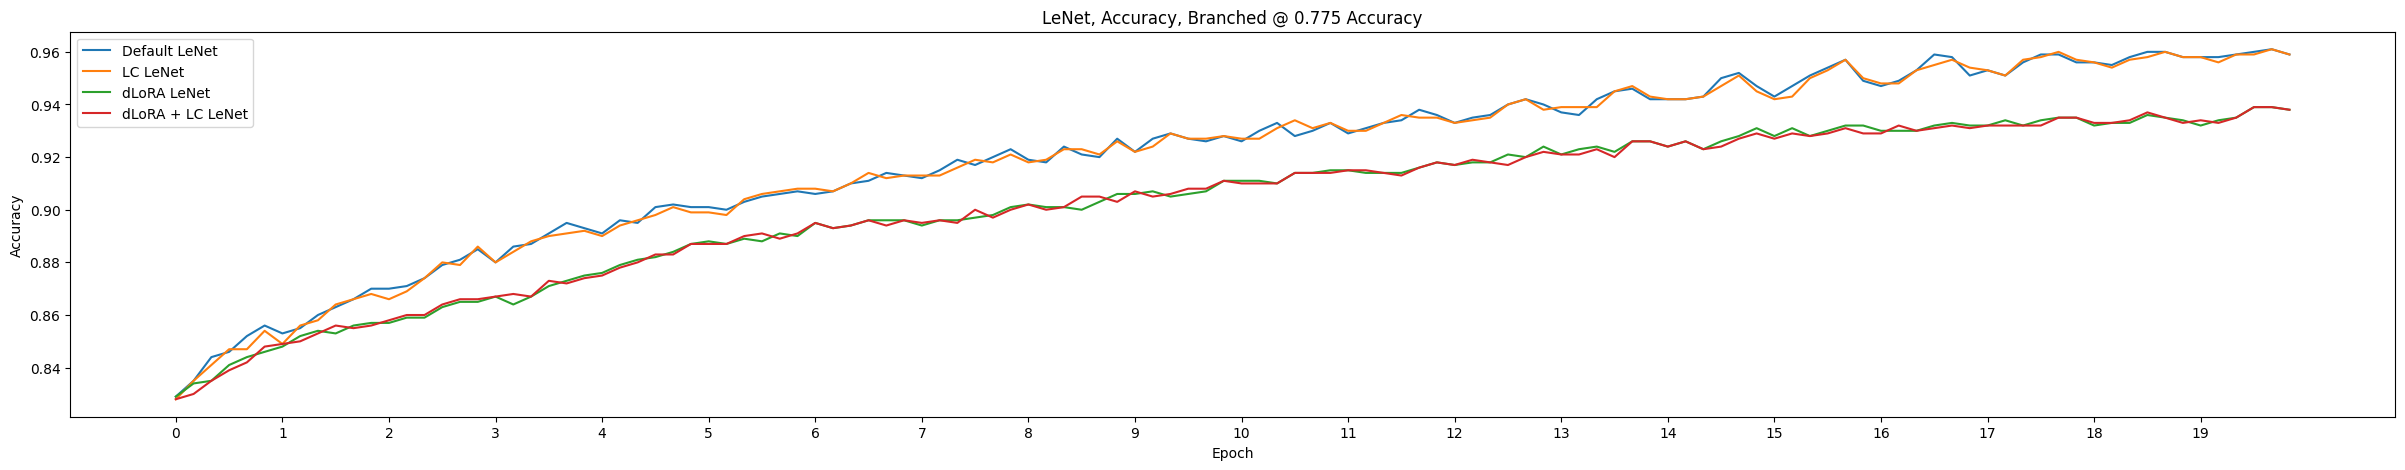

In [8]:
plt.figure(figsize = (30, 5))
plt.title("LeNet, Accuracy, Branched @ {} Accuracy".format(BRANCH_ACC))
plt.plot(full_accuracy, label = "Default LeNet")
plt.plot(lc_accuracy, label = "LC LeNet")
plt.plot(decomposed_full_accuracy, label = "dLoRA LeNet")
plt.plot(restored_accuracy, label = "dLoRA + LC LeNet")
plt.xticks([x for x in range(0, 120) if x % 6 == 0], [x for x in range(0, 20)])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [13]:
model.state_dict().keys()

odict_keys(['feature.0.weight', 'feature.0.bias', 'feature.3.weight', 'feature.3.bias', 'classifier.1.alpha', 'classifier.1.beta', 'classifier.1.bias', 'classifier.3.alpha', 'classifier.3.beta', 'classifier.3.bias', 'classifier.5.weight', 'classifier.5.bias'])

In [19]:
model.state_dict()['feature.3.weight'].shape

torch.Size([16, 6, 5, 5])

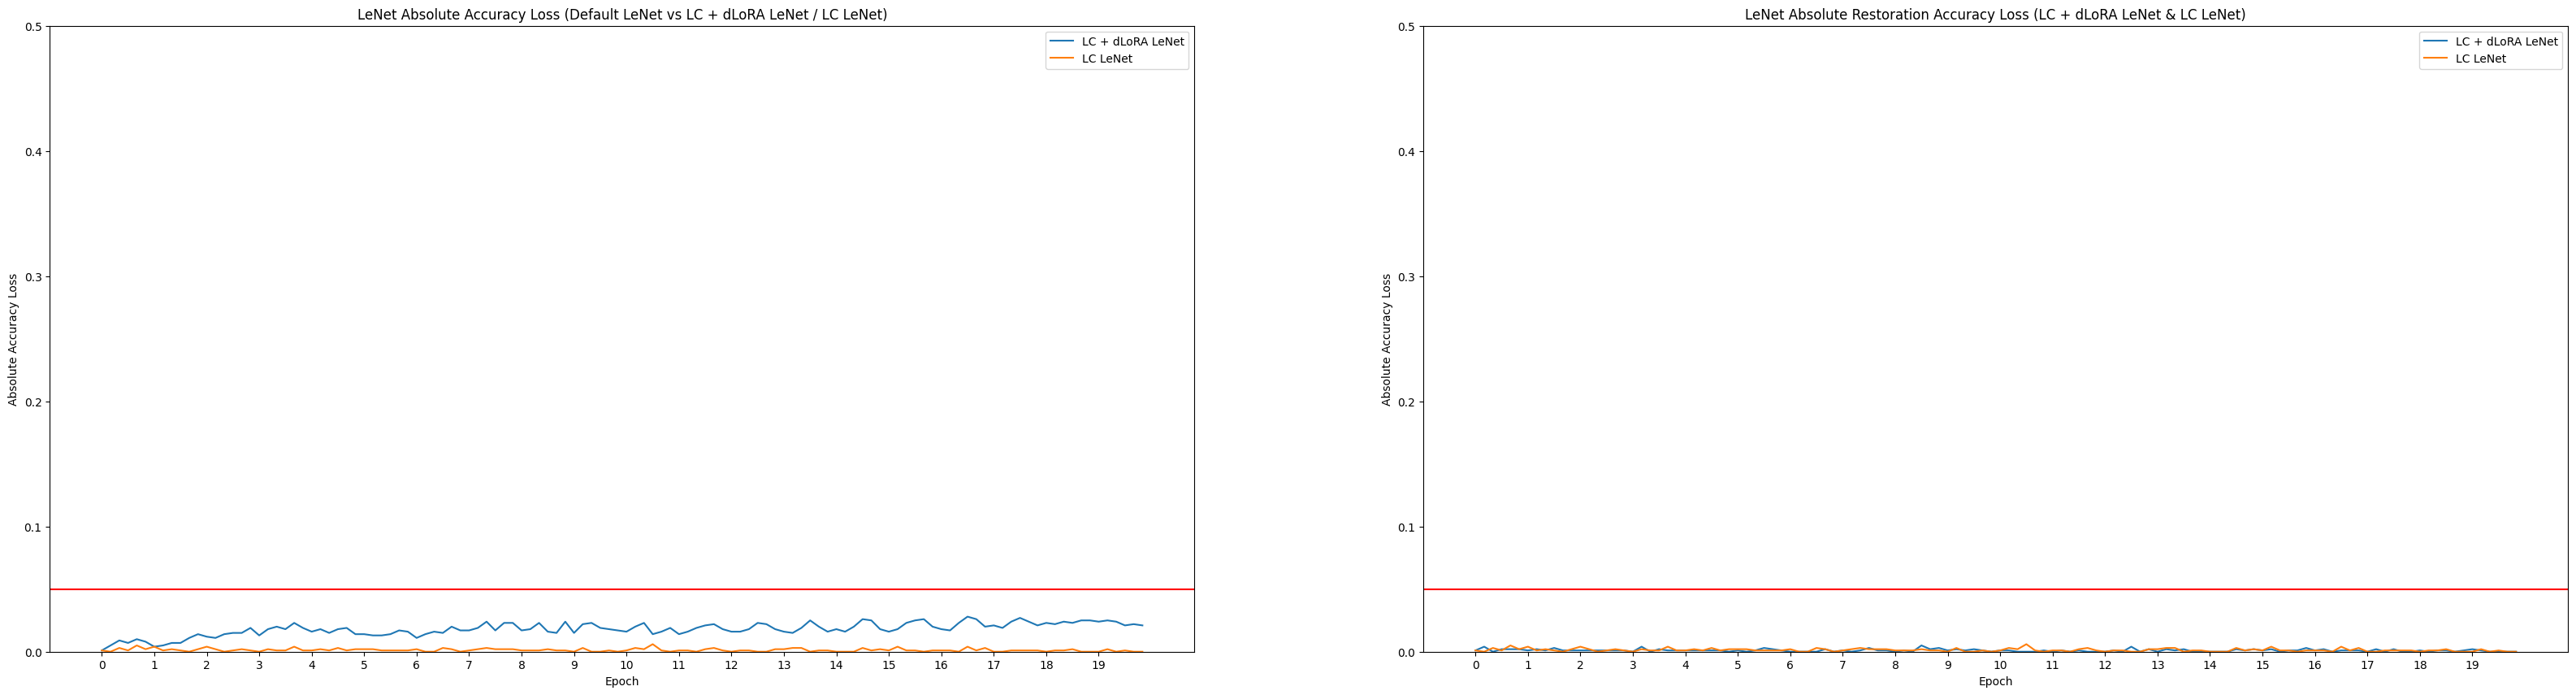

In [9]:
rangex = [x for x in range(0, 120) if x % 6 == 0]
rangey = [x for x in range(0, 20)]
plt.figure(figsize = (40, 10))
ax1 = plt.subplot(1, 2, 1)
ax1.set_title("LeNet Absolute Accuracy Loss (Default LeNet vs LC + dLoRA LeNet / LC LeNet)")
plt.plot(np.abs(np.subtract(np.array(full_accuracy), 
                     np.array(restored_accuracy))), label = "LC + dLoRA LeNet")
plt.plot(np.abs(np.subtract(np.array(full_accuracy), 
                     np.array(lc_accuracy))), label = "LC LeNet")
plt.legend()
plt.xticks(rangex, rangey)
plt.ylabel("Absolute Accuracy Loss")
plt.xlabel("Epoch")
plt.axhline(y = 0.05, color = 'r')
plt.ylim(0, 0.5)
ax2 = plt.subplot(1, 2, 2)
ax2.set_title("LeNet Absolute Restoration Accuracy Loss (LC + dLoRA LeNet & LC LeNet)")
plt.plot(np.abs(np.subtract(np.array(restored_accuracy), 
                     np.array(decomposed_full_accuracy))), label = "LC + dLoRA LeNet")
plt.plot(np.abs(np.subtract(np.array(full_accuracy), 
                     np.array(lc_accuracy))), label = "LC LeNet")
plt.legend()
plt.ylim(0, 0.5)
plt.axhline(y = 0.05, color = 'r')
plt.xticks(rangex, rangey)
plt.ylabel("Absolute Accuracy Loss")
plt.xlabel("Epoch")
plt.show()

In [17]:
import math
def getsize(sl):
    dir = [x for x in os.listdir(sl)]
    csize, usize = 0, 0
    for set in dir:
        for f in os.listdir(sl + "/" + set):
            fp = sl + "/{}/{}".format(set, f)
            csize += os.path.getsize(fp)
            usize += 250 * math.pow(2, 10) # torch checkpoint same size
    return csize, usize,

In [18]:
compressed_size, uncompressed_size = getsize(SAVE_LOC)
a, b = evaluate_compression(uncompressed_size, compressed_size)
compressed_size, uncompressed_size = getsize(SAVE_LOC_OLC)
a1, b1 = evaluate_compression(uncompressed_size, compressed_size)

print("LC-Checkpoint + GZIP")
print("Compression Ratio: {}%, Space Savings: {}%".format(a1, b1))
print("LoRA + LC-Checkpoint + GZIP")
print("Compression Ratio: {}%, Space Savings: {}%".format(a, b))

LC-Checkpoint + GZIP
Compression Ratio: 537.5840000000001%, Space Savings: 81.39800000000001%
LoRA + LC-Checkpoint + GZIP
Compression Ratio: 1427.2169999999999%, Space Savings: 92.99300000000001%


In [19]:
import json
data = {
    "full_acc" : full_accuracy,
    "decomposed_restored_accuracy" : restored_accuracy,
    "decomposed_full_accuracy" : decomposed_full_accuracy,
    "lc_restored_accuracy" : lc_accuracy
}
with open(HDFP + "/lobranch-snapshot/diffbitwidth-adaptive-rank/lenet/data.json", 'w') as f:
    json.dump(data, f)